<a href="https://colab.research.google.com/github/rakshita-vijay/pytorch/blob/main/pt_005_convolution_nn_mnist_number_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.metrics import confusion_matrix

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [6]:
# convert mnist image files into tensor of 4 dimensions = [# of images, height, width, color channel]
transform = transforms.ToTensor()

In [7]:
# train data
train_data = datasets.MNIST(root='/cnn_mnist_data', train=True, download=True, transform=transform)

In [8]:
test_data = datasets.MNIST(root='/cnn_mnist_data', train=False, download=True, transform=transform)

In [9]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: /cnn_mnist_data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: /cnn_mnist_data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [10]:
pwd

'/content'

In [11]:
# we want small batch sizes - 10, maybe?
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [12]:
# define cnn model
# describe convolutional layers - here, 2
# this is just an example
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)

In [13]:
# grab 1 mnist record/image
for i, (x_train, y_train) in enumerate(train_data):
    break

In [14]:
x_train.shape, y_train

(torch.Size([1, 28, 28]), 5)

In [15]:
x = x_train.view(1,1,28,28)

In [16]:
# perform out first convolution
x = F.relu(conv1(x))

In [17]:
x.shape

torch.Size([1, 6, 26, 26])

In [18]:
# 1 - single image
# 6 - filters we asked for
# 26x26 - image size - because mnsit data set has a padding, which we are not setting because we don't need it

In [19]:
# describe pooling layer
x = F.max_pool2d(x, 2, 2) # kernel = 2, stride = 2

In [20]:
# this basically shrinks it
x.shape

torch.Size([1, 6, 13, 13])

In [21]:
# perform out second convolution
x = F.relu(conv2(x))
x.shape

torch.Size([1, 16, 11, 11])

In [22]:
x = F.max_pool2d(x, 2, 2)
x.shape

torch.Size([1, 16, 5, 5])

In [23]:
# it is round down because we can't invent data to round up

convolution_1 : 28 - 2 = 26

padding_1 : (28 - 2) / 2 = 26 / 2 = 13

---

convolution_2 : ((28 - 2) / 2) - 2 = 13 - 2 = 11

padding_2 : (((28 - 2) / 2) - 2) / 2 = 11 / 2 = 5

In [24]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)

    # fully connected layers
    self.fc1 = nn.Linear(in_features=5*5*16, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.fc3 = nn.Linear(in_features=84, out_features=10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)

    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)

    x = x.view(-1, 5*5*16)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return F.log_softmax(x, dim=1)

In [25]:
# create an instance of our model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [26]:
# loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # smaller the learning rate, longer it takes to learn

In [27]:
import time
start_time = time.time()

# create variables to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# for loops of epochs
for epoch in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # train
  for batch, (x_trn, y_trn) in enumerate(train_loader):
    batch += 1 # start our batches at 1
    y_pred = model(x_trn) # get predicted values from our training set, unflattened
    loss = criterion(y_pred, y_trn) # compare predictions to correct answers

    predicted = torch.max(y_pred.data, 1)[1] # add the num of corr preds
    batch_corr = (predicted == y_trn).sum() # how many corr in this batch
    trn_corr += batch_corr

    # update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print our results
    if batch%600 == 0:
      print(f"Epoch: {epoch} | Batch: {batch} | Loss: {loss.item()}")

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # test
  with torch.no_grad(): # no update so we don't update wts and biases
    for batch, (x_tst, y_tst) in enumerate(test_loader):
      y_val = model(x_tst)

      predicted = torch.max(y_val.data, 1)[1] # add the num of corr preds
      tst_corr += (predicted == y_tst).sum() # how many corr in this batch

  loss = criterion(y_val, y_tst)
  test_losses.append(loss)
  test_correct.append(tst_corr)


end_time = time.time()

total_time = end_time - start_time
print("Training took:", total_time//60, "minutes and", total_time%60, "seconds!")

Epoch: 0 | Batch: 600 | Loss: 0.1623610556125641
Epoch: 0 | Batch: 1200 | Loss: 0.1502392590045929
Epoch: 0 | Batch: 1800 | Loss: 0.4744560718536377
Epoch: 0 | Batch: 2400 | Loss: 0.14238706231117249
Epoch: 0 | Batch: 3000 | Loss: 0.007758188061416149
Epoch: 0 | Batch: 3600 | Loss: 0.3836284875869751
Epoch: 0 | Batch: 4200 | Loss: 0.0038223876617848873
Epoch: 0 | Batch: 4800 | Loss: 0.0021286322735249996
Epoch: 0 | Batch: 5400 | Loss: 0.0569545142352581
Epoch: 0 | Batch: 6000 | Loss: 0.00038789428072050214
Epoch: 1 | Batch: 600 | Loss: 0.005851339548826218
Epoch: 1 | Batch: 1200 | Loss: 0.3855525553226471
Epoch: 1 | Batch: 1800 | Loss: 0.004819948226213455
Epoch: 1 | Batch: 2400 | Loss: 0.003216963727027178
Epoch: 1 | Batch: 3000 | Loss: 0.0332382395863533
Epoch: 1 | Batch: 3600 | Loss: 0.5372857451438904
Epoch: 1 | Batch: 4200 | Loss: 0.04561494290828705
Epoch: 1 | Batch: 4800 | Loss: 0.0007510822033509612
Epoch: 1 | Batch: 5400 | Loss: 0.0001173773780465126
Epoch: 1 | Batch: 6000 | L

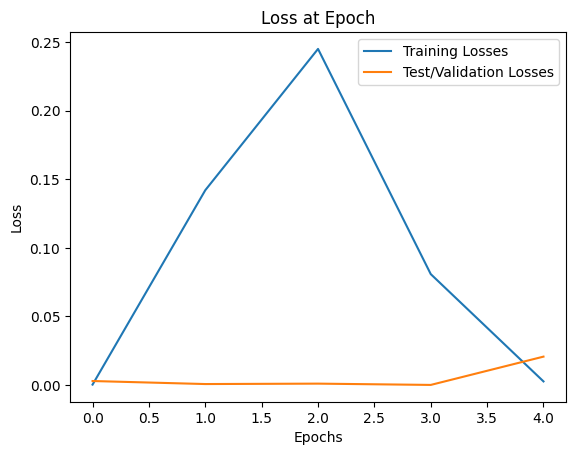

In [29]:
# graph the loss at each epoch
trn_losses = [trl.item() for trl in train_losses]
plt.plot(trn_losses, label="Training Losses")
plt.plot(test_losses, label="Test/Validation Losses")
plt.title("Loss at Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

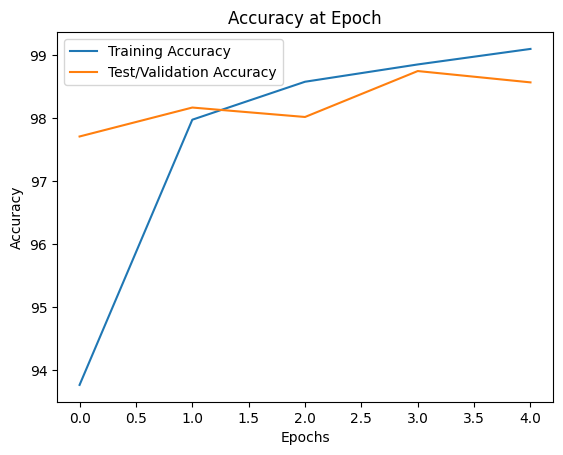

In [30]:
# graph the accuracy
plt.plot([t.item()/600 for t in train_correct], label="Training Accuracy")
plt.plot([t.item()/100 for t in test_correct], label="Test/Validation Accuracy")
plt.title("Accuracy at Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [36]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [37]:
with torch.no_grad():
  crct = 0
  for x_test, y_test in test_load_everything:
    y_val = model(x_test)
    predicted = torch.max(y_val, 1)[1]
    crct += (predicted == y_test).sum()

In [40]:
crct.item()/len(test_data)

0.9857

In [42]:
test_data[4143]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [43]:
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [44]:
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

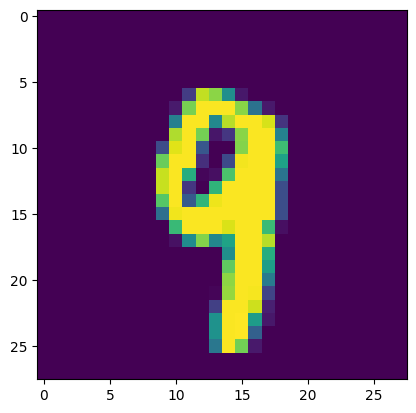

In [46]:
plt.imshow(test_data[4143][0].reshape(28,28))

In [47]:
# pass the img through our model
model.eval()
with torch.no_grad():
  new_pred = model(test_data[4143][0].view(1,1,28,28))

In [48]:
new_pred

tensor([[-2.1693e+01, -1.8584e+01, -2.1709e+01, -1.5842e+01, -8.6330e+00,
         -1.8415e+01, -3.1769e+01, -1.2734e+01, -1.3396e+01, -1.8273e-04]])

In [49]:
new_pred.argmax()

tensor(9)

tensor(3)

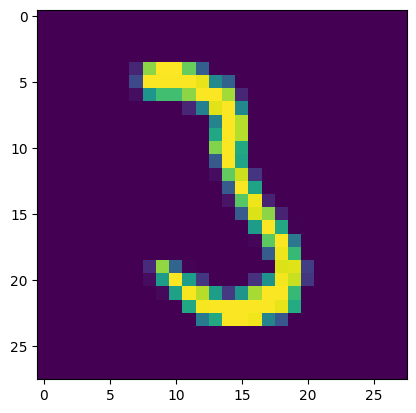

In [52]:
test_data[1789][0].reshape(28,28)
plt.imshow(test_data[1789][0].reshape(28,28))
model.eval()
with torch.no_grad():
  new_pred_1789 = model(test_data[1789][0].view(1,1,28,28))
new_pred_1789.argmax()